In [1]:

import os
import time
import json
import hashlib
from pathlib import Path
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import timm

# -----------------------
# CONFIG (tweak these)
# -----------------------
DATA_DIR = Path(r"/home/phamtiendat/Documents/ComputerVision/Image_processing/Dataset_preprocessed")
OUTPUT_DIR = Path("weights_resnet50_head_custom")
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 200        # expanded epoch budget for slow asymptotic climb
LR = 1e-6               # base LR (small to slow convergence)
WARMUP_EPOCHS = 20      # long warmup
PLATEAU_UNTIL = 20      # keep LR plateau until this epoch (1-based)
WEIGHT_DECAY = 1e-3
NUM_WORKERS = 4
USE_AMP = True
MIXUP = False
SEED = 42

FREEZE_BACKBONE = False     # if True, freeze backbone until UNFREEZE_AT
UNFREEZE_AT = 21            # epoch to unfreeze backbone if FREEZE_BACKBONE True

OUTPUT_DIR.mkdir(exist_ok=True)
print("DATA_DIR:", DATA_DIR)

# -----------------------
# Device & reproducibility
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except Exception:
        pass

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------
# Dataset transforms / loaders
# -----------------------
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.05)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.01, 0.05))
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(str(DATA_DIR / "train"), transform=train_tf)
val_ds = datasets.ImageFolder(str(DATA_DIR / "val"), transform=val_tf)
test_ds = datasets.ImageFolder(str(DATA_DIR / "test"), transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Classes:", train_ds.classes)
print("Counts:", len(train_ds), len(val_ds), len(test_ds))

# -----------------------
# Model: timm ResNet50 backbone + custom head
# -----------------------
num_classes = len(train_ds.classes)
backbone = timm.create_model("resnet50", pretrained=True)
in_f = backbone.fc.in_features

custom_head = nn.Sequential(
    nn.Linear(in_f, 512),
    nn.ELU(inplace=True),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.2),
    nn.Linear(512, 128),
    nn.ELU(inplace=True),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.2),
    nn.Linear(128, num_classes)
)
backbone.fc = custom_head
model = backbone.to(device)

# -----------------------
# Loss / Optimizer / Scheduler / AMP
# -----------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

DATA_DIR: /home/phamtiendat/Documents/ComputerVision/Image_processing/Dataset_preprocessed
Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Classes: ['Nail_psoriasis', 'SJS-TEN', 'Unknown_Normal', 'Vitiligo', 'acne', 'hyperpigmentation']
Counts: 23544 5271 2469


In [ ]:
def make_lr_lambda(num_epochs, warmup_epochs, plateau_until=20, final_scale=1e-3, plateau_scale=0.8):
    """
    Returns a lambda that maps epoch_index (0-based) -> multiplier for base LR.
    Behavior:
      - linear warmup from 0.01 to 1.0 across warmup_epochs
      - plateau scale until plateau_until (1-based epoch)
      - smooth polynomial decay from plateau_scale down to final_scale by num_epochs
    """
    def lr_lambda(epoch):
        # epoch is 0-based; convert checks accordingly
        if epoch < warmup_epochs:
            return 0.01 + 0.99 * (epoch / max(1, warmup_epochs - 1))
        # plateau_until provided as 1-based epoch threshold; convert to 0-based index
        plateau_idx = max(0, plateau_until - 1)
        if epoch <= plateau_idx:
            return plateau_scale
        # decay region
        t = (epoch - plateau_idx) / max(1, (num_epochs - 1 - plateau_idx))
        # polynomial decay for smoothness (exponent 1.5)
        return max(final_scale, plateau_scale * (1 - t)**1.5)
    return lr_lambda

lr_lambda = make_lr_lambda(NUM_EPOCHS, WARMUP_EPOCHS, plateau_until=PLATEAU_UNTIL, final_scale=1e-4, plateau_scale=0.8)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler() if (USE_AMP and device.type == "cuda") else None

# -----------------------
# Train / Validate helpers (kept consistent with your original)
# -----------------------
def mixup_data(x, y, alpha=0.2):
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_one_epoch(model, loader, optimizer, criterion, device, scaler, use_mixup=False, mixup_alpha=0.2):
    model.train()
    running_loss = 0.0
    running_corrects = 0.0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_mixup:
            inputs, y_a, y_b, lam = mixup_data(inputs, labels, mixup_alpha)
            with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                outputs = model(inputs)
                loss = lam * criterion(outputs, y_a) + (1-lam) * criterion(outputs, y_b)
        else:
            with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        _, preds = torch.max(outputs, 1)
        bs = inputs.size(0)
        running_loss += loss.item() * bs
        if not use_mixup:
            running_corrects += torch.sum(preds == labels).item()
        else:
            running_corrects += (lam * torch.sum(preds == y_a).item() + (1-lam) * torch.sum(preds == y_b).item())
        total += bs
    return running_loss / total, running_corrects / total

@torch.no_grad()
def validate(model, loader, criterion, device, use_amp=False):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.cuda.amp.autocast(enabled=(use_amp and (scaler is not None))):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        bs = inputs.size(0)
        running_loss += loss.item() * bs
        running_corrects += torch.sum(preds == labels).item()
        total += bs
    return running_loss / total, running_corrects / total

# -----------------------
# Optional backbone freezing (controlled flag)
# -----------------------
def freeze_backbone_except_head(model):
    for name, p in model.named_parameters():
        if "fc" not in name:  # keeps head trainable, freezes backbone
            p.requires_grad = False

def unfreeze_all(model):
    for p in model.parameters():
        p.requires_grad = True

if FREEZE_BACKBONE:
    freeze_backbone_except_head(model)
    print(f"Backbone frozen until epoch {UNFREEZE_AT} (head-only training)")


/tmp/ipykernel_38196/3323785978.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (USE_AMP and device.type == "cuda") else None


In [3]:
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val = -1.0

try:
    for epoch in range(1, NUM_EPOCHS + 1):
        t0 = time.time()

        # Optionally unfreeze backbone at configured epoch
        if FREEZE_BACKBONE and epoch == UNFREEZE_AT:
            print(f"Unfreezing backbone at epoch {epoch}")
            unfreeze_all(model)
            # Recreate optimizer with full model params (important if parameters changed requires_grad)
            optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
            # Reattach scheduler with same lr_lambda but for new optimizer reference
            scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler, use_mixup=MIXUP, mixup_alpha=0.2)
        val_loss, val_acc = validate(model, val_loader, criterion, device, use_amp=USE_AMP)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # scheduler step per epoch
        scheduler.step()

        elapsed = time.time() - t0
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}/{NUM_EPOCHS} - LR {current_lr:.2e} - train_loss {train_loss:.4f} train_acc {train_acc:.4f} | val_loss {val_loss:.4f} val_acc {val_acc:.4f} | time {elapsed:.1f}s")

        # save last checkpoint
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_acc": float(val_acc),
            "classes": train_ds.classes
        }, OUTPUT_DIR / "last.pth")

        # save best
        if val_acc > best_val + 1e-6:
            best_val = val_acc
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_acc": float(val_acc),
                "classes": train_ds.classes
            }, OUTPUT_DIR / "best.pth")
            print(" -> saved best.pth")

        torch.cuda.empty_cache()

except KeyboardInterrupt:
    print("Interrupted by user, saving current last.pth and exiting.")
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "val_acc": float(val_acc) if 'val_acc' in locals() else -1.0,
        "classes": train_ds.classes
    }, OUTPUT_DIR / "last_interrupt.pth")
    raise

print("Training finished. Best val:", best_val)

/tmp/ipykernel_38196/3323785978.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):
/tmp/ipykernel_38196/3323785978.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and (scaler is not None))):


Epoch 1/200 - LR 6.21e-08 - train_loss 1.9364 train_acc 0.1780 | val_loss 1.9003 val_acc 0.1713 | time 112.3s
 -> saved best.pth
Epoch 2/200 - LR 1.14e-07 - train_loss 1.9207 train_acc 0.1844 | val_loss 1.8487 val_acc 0.1964 | time 111.6s
 -> saved best.pth
Epoch 3/200 - LR 1.66e-07 - train_loss 1.8831 train_acc 0.1985 | val_loss 1.7893 val_acc 0.2260 | time 105.4s
 -> saved best.pth
Epoch 4/200 - LR 2.18e-07 - train_loss 1.8297 train_acc 0.2289 | val_loss 1.7356 val_acc 0.2647 | time 105.6s
 -> saved best.pth
Epoch 5/200 - LR 2.71e-07 - train_loss 1.7494 train_acc 0.2733 | val_loss 1.6842 val_acc 0.3087 | time 105.0s
 -> saved best.pth
Epoch 6/200 - LR 3.23e-07 - train_loss 1.6699 train_acc 0.3230 | val_loss 1.6174 val_acc 0.3637 | time 105.9s
 -> saved best.pth
Epoch 7/200 - LR 3.75e-07 - train_loss 1.5876 train_acc 0.3843 | val_loss 1.5375 val_acc 0.4307 | time 105.7s
 -> saved best.pth
Epoch 8/200 - LR 4.27e-07 - train_loss 1.4993 train_acc 0.4379 | val_loss 1.4610 val_acc 0.4800 |

KeyboardInterrupt: 

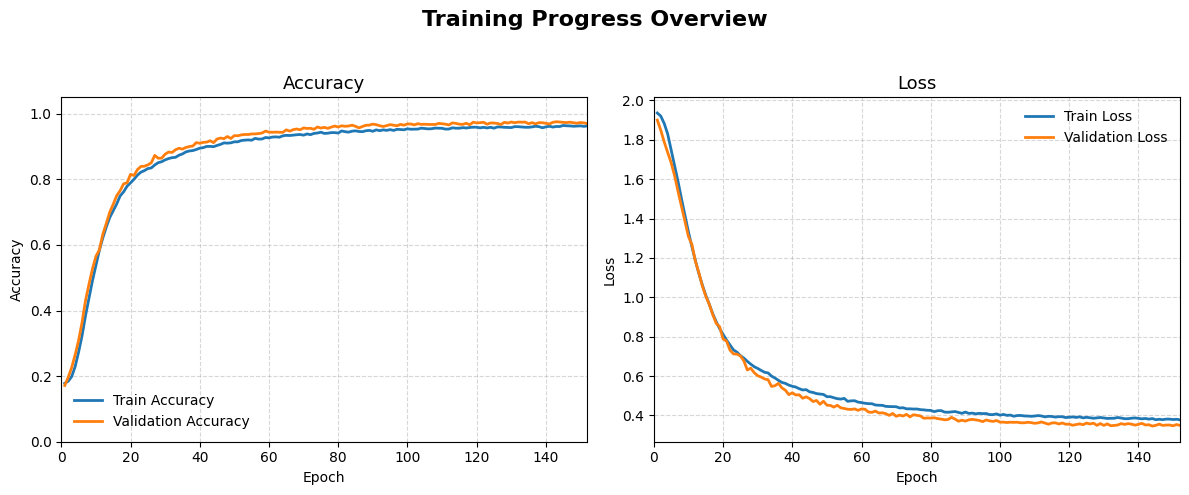

In [4]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))
plt.suptitle("Training Progress Overview", fontsize=16, fontweight='bold')

# ---- Accuracy subplot ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_acc"], color="#1f77b4", linewidth=2, label="Train Accuracy")
plt.plot(epochs, history["val_acc"], color="#ff7f0e", linewidth=2, label="Validation Accuracy")
plt.title("Accuracy", fontsize=13)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(frameon=False)
plt.xlim(0, len(epochs))
plt.ylim(0, 1.05)

# ---- Loss subplot ----
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_loss"], color="#1f77b4", linewidth=2, label="Train Loss")
plt.plot(epochs, history["val_loss"], color="#ff7f0e", linewidth=2, label="Validation Loss")
plt.title("Loss", fontsize=13)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(frameon=False)
plt.xlim(0, len(epochs))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()